<a href="https://colab.research.google.com/github/ucalyptus/BS-Nets-Implementation-Pytorch/blob/master/Pytorch_BSNetConv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [90]:
!pip install kornia

In [91]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
import os
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from scipy import io 
import torch.utils.data
import scipy
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [92]:
!pip install -U spectral

In [93]:
from src.DETCTCNN.data.music_2d_dataset import MUSIC2DDataset
import src.DETCTCNN.data.music_2d_dataset
path2d = "../MUSIC2D_HDF5"
path3d = "../MUSIC3D_HDF5"
transform = src.DETCTCNN.data.music_2d_dataset.JointTransform2D(crop=(7,7), p_flip=0, color_jitter_params=None, long_mask=True)
data_train = MUSIC2DDataset(
        path2d=path2d, path3d=path3d,
        partition="train", 
        spectrum="fullSpectrum",
        transform=transform, 
        full_dataset=True, 
)
train_loader = DataLoader(data_train, batch_size=16, shuffle=True)

In [94]:
print(data_train[0]["image"].shape)
print(data_train.__len__())

torch.Size([128, 7, 7])
437


In [95]:

class BSNET_Conv(nn.Module):

    def __init__(self,):
      
        super(BSNET_Conv, self).__init__()
        self.conv1 = nn.Sequential(
        	nn.Conv2d(128,64,(3,3),1,0),
        	nn.ReLU(True))

        self.conv1_1 = nn.Sequential(
        	nn.Conv2d(128,128,(3,3),1,0),
        	nn.ReLU(True))
        self.conv1_2 = nn.Sequential(
        	nn.Conv2d(128,64,(3,3),1,0),
        	nn.ReLU(True))
        
        self.deconv1_2 = nn.Sequential(
        	nn.ConvTranspose2d(64,64,(3,3),1,0),
        	nn.ReLU(True))
        
        self.deconv1_1 = nn.Sequential(
        	nn.ConvTranspose2d(64,128,(3,3),1,0),
        	nn.ReLU(True))

        self.conv2_1 = nn.Sequential(
        	nn.Conv2d(128,128,(1,1),1,0),
        	nn.Sigmoid())
        

        self.fc1 = nn.Sequential(
        	nn.Linear(64,128),
        	nn.ReLU(True))
        self.fc2 = nn.Sequential(
        	nn.Linear(128,128),
        	nn.Sigmoid())
        self.gp=nn.AvgPool2d(5)
    
        
    def BAM(self,x):
        
        x = self.conv1(x)
        
        
        x = self.gp(x)
        
        
        x = x.view(-1,64)
        
        x = self.fc1(x)
        
        x = self.fc2(x)
        
        x = x.view(-1,1,1,128)
        x = x.permute(0,3,1,2)
        
        return x

    def RecNet(self,x):

      x = self.conv1_1(x)
      
      x = self.conv1_2(x)
      
      x = self.deconv1_2(x)
      
      x = self.deconv1_1(x)
      
      x = self.conv2_1(x)
      
      return x
      
      

    def forward(self,x):
      
      BRW = self.BAM(x)
      
      x = x*BRW
      ret = self.RecNet(x)
      
      return ret


       
model = BSNET_Conv()

In [96]:
from torchsummary import summary
summary(model,(128,7,7),batch_size=16)
model = model.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [16, 64, 5, 5]          73,792
              ReLU-2             [16, 64, 5, 5]               0
         AvgPool2d-3             [16, 64, 1, 1]               0
            Linear-4                  [16, 128]           8,320
              ReLU-5                  [16, 128]               0
            Linear-6                  [16, 128]          16,512
           Sigmoid-7                  [16, 128]               0
            Conv2d-8            [16, 128, 5, 5]         147,584
              ReLU-9            [16, 128, 5, 5]               0
           Conv2d-10             [16, 64, 3, 3]          73,792
             ReLU-11             [16, 64, 3, 3]               0
  ConvTranspose2d-12             [16, 64, 5, 5]          36,928
             ReLU-13             [16, 64, 5, 5]               0
  ConvTranspose2d-14            [16, 12

In [97]:
top = 10
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), betas=([0.9, 0.999]), lr = 0.1)

In [98]:
import skimage
import kornia
global bsnlist
ssim = kornia.losses.SSIMLoss(5, reduction='none')
psnr = kornia.losses.PSNRLoss(2500)
from skimage import measure
ssim_list = []
psnr_list = []
l1_list = []
channel_weight_list = []
def train(epoch):    
    model.train()
    ENTROPY = torch.zeros(128)

    for batch_idx, data in enumerate(train_loader):
        data = data["image"].to(device)
        optimizer.zero_grad()
        output =  model(data)
        loss = F.l1_loss(output,data)
        loss.backward()
        optimizer.step()
        D = output.detach().cpu().numpy()
        for i in range(0,128):

          ENTROPY[i]+=skimage.measure.shannon_entropy(D[:,i,:,:])
        
        if batch_idx % (0.5*len(train_loader)) == 0:



            L1 = loss.item()
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),L1))
            l1_list.append(L1)
            ssim_val = torch.mean(ssim(data,output))
            print("SSIM: {}".format(ssim_val))
            ssim_list.append(ssim_val)
            psnr_val = psnr(data,output)
            print("PSNR: {}".format(psnr_val))
            psnr_list.append(psnr_val)
        
        
    ENTROPY = np.array(ENTROPY)
    bsnlist = np.asarray(ENTROPY.argsort()[-top:][::-1])
    print('Top {} bands with Entropy ->'.format(top),list(bsnlist))
    
    


for epoch in range(0, 500):
    train(epoch)
    

Train Epoch: 0 [0/437 (0%)]	Loss: 0.327942
SSIM: 0.27045905590057373
PSNR: -76.69546508789062
Train Epoch: 0 [224/437 (50%)]	Loss: 0.284321
SSIM: 0.49744465947151184
PSNR: -75.40496826171875
Top 10 bands with Entropy -> [65, 112, 4, 17, 53, 84, 46, 117, 27, 29]
Train Epoch: 1 [0/437 (0%)]	Loss: 0.270446
SSIM: 0.4884021580219269
PSNR: -75.44438934326172
Train Epoch: 1 [224/437 (50%)]	Loss: 0.287592
SSIM: 0.49709179997444153
PSNR: -75.71614074707031
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 2 [0/437 (0%)]	Loss: 0.269072
SSIM: 0.4941924214363098
PSNR: -75.99723815917969
Train Epoch: 2 [224/437 (50%)]	Loss: 0.262757
SSIM: 0.49247580766677856
PSNR: -75.23518371582031
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 3 [0/437 (0%)]	Loss: 0.299102
SSIM: 0.48282361030578613
PSNR: -74.28429412841797
Train Epoch: 3 [224/437 (50%)]	Loss: 0.279845
SSIM: 0.4959835112094879
PSNR: -75.76838684082031
Top 10 bands with Entrop

Train Epoch: 31 [224/437 (50%)]	Loss: 0.284179
SSIM: 0.48893436789512634
PSNR: -75.11004638671875
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 32 [0/437 (0%)]	Loss: 0.303121
SSIM: 0.48541155457496643
PSNR: -74.21746063232422
Train Epoch: 32 [224/437 (50%)]	Loss: 0.288165
SSIM: 0.49181339144706726
PSNR: -74.85401916503906
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 33 [0/437 (0%)]	Loss: 0.286246
SSIM: 0.4947246313095093
PSNR: -74.4325942993164
Train Epoch: 33 [224/437 (50%)]	Loss: 0.291210
SSIM: 0.48387232422828674
PSNR: -74.43331909179688
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 34 [0/437 (0%)]	Loss: 0.270546
SSIM: 0.4968292713165283
PSNR: -75.90788269042969
Train Epoch: 34 [224/437 (50%)]	Loss: 0.234160
SSIM: 0.48711565136909485
PSNR: -76.87432861328125
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 35 [0/437 (0%)]	Loss: 0.2

Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 63 [0/437 (0%)]	Loss: 0.251987
SSIM: 0.4867932200431824
PSNR: -76.63247680664062
Train Epoch: 63 [224/437 (50%)]	Loss: 0.273388
SSIM: 0.49093738198280334
PSNR: -75.550048828125
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 64 [0/437 (0%)]	Loss: 0.281609
SSIM: 0.495540976524353
PSNR: -75.2110366821289
Train Epoch: 64 [224/437 (50%)]	Loss: 0.289816
SSIM: 0.49482595920562744
PSNR: -75.21454620361328
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 65 [0/437 (0%)]	Loss: 0.274421
SSIM: 0.49022558331489563
PSNR: -75.66766357421875
Train Epoch: 65 [224/437 (50%)]	Loss: 0.257511
SSIM: 0.48445266485214233
PSNR: -75.92232513427734
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 66 [0/437 (0%)]	Loss: 0.247711
SSIM: 0.48032161593437195
PSNR: -75.99310302734375
Train Epoch: 66 [224/437 (50%)]	Loss: 0.2910

Train Epoch: 94 [224/437 (50%)]	Loss: 0.288023
SSIM: 0.4987180233001709
PSNR: -76.01206970214844
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 95 [0/437 (0%)]	Loss: 0.268307
SSIM: 0.4907066226005554
PSNR: -75.30442810058594
Train Epoch: 95 [224/437 (50%)]	Loss: 0.312313
SSIM: 0.48244574666023254
PSNR: -74.3392562866211
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 96 [0/437 (0%)]	Loss: 0.245384
SSIM: 0.48277217149734497
PSNR: -75.75407409667969
Train Epoch: 96 [224/437 (50%)]	Loss: 0.246686
SSIM: 0.4911828637123108
PSNR: -76.59178924560547
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 97 [0/437 (0%)]	Loss: 0.292465
SSIM: 0.4938317537307739
PSNR: -74.81848907470703
Train Epoch: 97 [224/437 (50%)]	Loss: 0.270692
SSIM: 0.49712279438972473
PSNR: -75.94827270507812
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 98 [0/437 (0%)]	Loss: 0.282

Train Epoch: 125 [224/437 (50%)]	Loss: 0.244069
SSIM: 0.48059311509132385
PSNR: -76.08515930175781
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 126 [0/437 (0%)]	Loss: 0.335002
SSIM: 0.4938684105873108
PSNR: -73.8450698852539
Train Epoch: 126 [224/437 (50%)]	Loss: 0.261473
SSIM: 0.48673832416534424
PSNR: -75.75527954101562
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 127 [0/437 (0%)]	Loss: 0.311854
SSIM: 0.48924461007118225
PSNR: -74.13811492919922
Train Epoch: 127 [224/437 (50%)]	Loss: 0.315772
SSIM: 0.49611780047416687
PSNR: -74.45500183105469
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 128 [0/437 (0%)]	Loss: 0.305530
SSIM: 0.4955426752567291
PSNR: -74.8697280883789
Train Epoch: 128 [224/437 (50%)]	Loss: 0.241529
SSIM: 0.4769327938556671
PSNR: -76.0973892211914
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 129 [0/437 (0%)]	Loss

Train Epoch: 156 [224/437 (50%)]	Loss: 0.301110
SSIM: 0.48114314675331116
PSNR: -74.41185760498047
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 157 [0/437 (0%)]	Loss: 0.250045
SSIM: 0.49140578508377075
PSNR: -76.70209503173828
Train Epoch: 157 [224/437 (50%)]	Loss: 0.271451
SSIM: 0.49412044882774353
PSNR: -75.7000732421875
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 158 [0/437 (0%)]	Loss: 0.273891
SSIM: 0.49384957551956177
PSNR: -75.5716552734375
Train Epoch: 158 [224/437 (50%)]	Loss: 0.238330
SSIM: 0.4788060486316681
PSNR: -75.99340057373047
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 159 [0/437 (0%)]	Loss: 0.307908
SSIM: 0.49678200483322144
PSNR: -74.72949981689453
Train Epoch: 159 [224/437 (50%)]	Loss: 0.215664
SSIM: 0.4822799563407898
PSNR: -77.10069274902344
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 160 [0/437 (0%)]	Lo

Train Epoch: 187 [224/437 (50%)]	Loss: 0.313203
SSIM: 0.4927447438240051
PSNR: -74.20267486572266
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 188 [0/437 (0%)]	Loss: 0.286211
SSIM: 0.4961117208003998
PSNR: -74.91766357421875
Train Epoch: 188 [224/437 (50%)]	Loss: 0.234221
SSIM: 0.4898499846458435
PSNR: -76.40805053710938
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 189 [0/437 (0%)]	Loss: 0.210249
SSIM: 0.4899556338787079
PSNR: -78.27952575683594
Train Epoch: 189 [224/437 (50%)]	Loss: 0.275899
SSIM: 0.4801144599914551
PSNR: -75.0264892578125
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 190 [0/437 (0%)]	Loss: 0.301197
SSIM: 0.4879787862300873
PSNR: -74.56127166748047
Train Epoch: 190 [224/437 (50%)]	Loss: 0.276522
SSIM: 0.489596962928772
PSNR: -75.64966583251953
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 191 [0/437 (0%)]	Loss: 0

Train Epoch: 218 [224/437 (50%)]	Loss: 0.271868
SSIM: 0.49158912897109985
PSNR: -75.45646667480469
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 219 [0/437 (0%)]	Loss: 0.293749
SSIM: 0.488961786031723
PSNR: -75.11136627197266
Train Epoch: 219 [224/437 (50%)]	Loss: 0.277990
SSIM: 0.4854189455509186
PSNR: -75.11541748046875
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 220 [0/437 (0%)]	Loss: 0.246990
SSIM: 0.49805423617362976
PSNR: -76.851318359375
Train Epoch: 220 [224/437 (50%)]	Loss: 0.228798
SSIM: 0.48981961607933044
PSNR: -77.65105438232422
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 221 [0/437 (0%)]	Loss: 0.268825
SSIM: 0.49224671721458435
PSNR: -75.61607360839844
Train Epoch: 221 [224/437 (50%)]	Loss: 0.254387
SSIM: 0.47333261370658875
PSNR: -76.45570373535156
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 222 [0/437 (0%)]	Los

Train Epoch: 249 [224/437 (50%)]	Loss: 0.259329
SSIM: 0.48651546239852905
PSNR: -76.25233459472656
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 250 [0/437 (0%)]	Loss: 0.259506
SSIM: 0.4849078059196472
PSNR: -75.85658264160156
Train Epoch: 250 [224/437 (50%)]	Loss: 0.238425
SSIM: 0.4927319586277008
PSNR: -76.94318389892578
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 251 [0/437 (0%)]	Loss: 0.257558
SSIM: 0.4852774739265442
PSNR: -75.801513671875
Train Epoch: 251 [224/437 (50%)]	Loss: 0.251438
SSIM: 0.4836994409561157
PSNR: -75.86223602294922
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 252 [0/437 (0%)]	Loss: 0.259829
SSIM: 0.49078649282455444
PSNR: -76.1250228881836
Train Epoch: 252 [224/437 (50%)]	Loss: 0.264337
SSIM: 0.4936683177947998
PSNR: -76.28599548339844
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 253 [0/437 (0%)]	Loss: 

Train Epoch: 280 [224/437 (50%)]	Loss: 0.283209
SSIM: 0.4841233491897583
PSNR: -75.19501495361328
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 281 [0/437 (0%)]	Loss: 0.302679
SSIM: 0.49449899792671204
PSNR: -74.82886505126953
Train Epoch: 281 [224/437 (50%)]	Loss: 0.269113
SSIM: 0.4817519187927246
PSNR: -75.73383331298828
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 282 [0/437 (0%)]	Loss: 0.289119
SSIM: 0.49303388595581055
PSNR: -75.24137115478516
Train Epoch: 282 [224/437 (50%)]	Loss: 0.275859
SSIM: 0.4959408938884735
PSNR: -75.44557189941406
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 283 [0/437 (0%)]	Loss: 0.298971
SSIM: 0.4942508935928345
PSNR: -75.20195770263672
Train Epoch: 283 [224/437 (50%)]	Loss: 0.256004
SSIM: 0.4784194529056549
PSNR: -76.07791900634766
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 284 [0/437 (0%)]	Los

Train Epoch: 311 [224/437 (50%)]	Loss: 0.283207
SSIM: 0.4979475438594818
PSNR: -75.51220703125
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 312 [0/437 (0%)]	Loss: 0.245074
SSIM: 0.4859641194343567
PSNR: -76.2474365234375
Train Epoch: 312 [224/437 (50%)]	Loss: 0.296407
SSIM: 0.4948749244213104
PSNR: -74.60127258300781
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 313 [0/437 (0%)]	Loss: 0.247262
SSIM: 0.48618417978286743
PSNR: -76.3395004272461
Train Epoch: 313 [224/437 (50%)]	Loss: 0.311348
SSIM: 0.4976905882358551
PSNR: -74.60504913330078
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 314 [0/437 (0%)]	Loss: 0.265813
SSIM: 0.4934651851654053
PSNR: -75.91056060791016
Train Epoch: 314 [224/437 (50%)]	Loss: 0.304561
SSIM: 0.490621417760849
PSNR: -74.45156860351562
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 315 [0/437 (0%)]	Loss: 0.21

Train Epoch: 342 [224/437 (50%)]	Loss: 0.253560
SSIM: 0.4811592996120453
PSNR: -75.9104995727539
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 343 [0/437 (0%)]	Loss: 0.277275
SSIM: 0.4860166311264038
PSNR: -75.65316009521484
Train Epoch: 343 [224/437 (50%)]	Loss: 0.311959
SSIM: 0.49619272351264954
PSNR: -74.46537017822266
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 344 [0/437 (0%)]	Loss: 0.264517
SSIM: 0.49023547768592834
PSNR: -75.56744384765625
Train Epoch: 344 [224/437 (50%)]	Loss: 0.269959
SSIM: 0.49158206582069397
PSNR: -75.86764526367188
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 345 [0/437 (0%)]	Loss: 0.289262
SSIM: 0.49415871500968933
PSNR: -75.22100830078125
Train Epoch: 345 [224/437 (50%)]	Loss: 0.304296
SSIM: 0.4917786717414856
PSNR: -74.84396362304688
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 346 [0/437 (0%)]	Lo

Train Epoch: 373 [224/437 (50%)]	Loss: 0.292437
SSIM: 0.4969199001789093
PSNR: -75.02705383300781
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 374 [0/437 (0%)]	Loss: 0.258965
SSIM: 0.47969865798950195
PSNR: -75.48675537109375
Train Epoch: 374 [224/437 (50%)]	Loss: 0.297036
SSIM: 0.4947535991668701
PSNR: -74.65403747558594
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 375 [0/437 (0%)]	Loss: 0.295055
SSIM: 0.49191755056381226
PSNR: -74.36994171142578
Train Epoch: 375 [224/437 (50%)]	Loss: 0.249447
SSIM: 0.49451354146003723
PSNR: -76.54296875
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 376 [0/437 (0%)]	Loss: 0.252797
SSIM: 0.4938957393169403
PSNR: -76.6908950805664
Train Epoch: 376 [224/437 (50%)]	Loss: 0.240473
SSIM: 0.4952482581138611
PSNR: -77.18480682373047
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 377 [0/437 (0%)]	Loss: 0.2

Train Epoch: 404 [224/437 (50%)]	Loss: 0.249548
SSIM: 0.47285622358322144
PSNR: -75.45451354980469
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 405 [0/437 (0%)]	Loss: 0.262372
SSIM: 0.49484434723854065
PSNR: -75.92245483398438
Train Epoch: 405 [224/437 (50%)]	Loss: 0.272338
SSIM: 0.484973669052124
PSNR: -75.74664306640625
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 406 [0/437 (0%)]	Loss: 0.241944
SSIM: 0.4933319091796875
PSNR: -76.84098052978516
Train Epoch: 406 [224/437 (50%)]	Loss: 0.264139
SSIM: 0.48477232456207275
PSNR: -75.66645050048828
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 407 [0/437 (0%)]	Loss: 0.260844
SSIM: 0.4966205656528473
PSNR: -76.06124877929688
Train Epoch: 407 [224/437 (50%)]	Loss: 0.252141
SSIM: 0.49165964126586914
PSNR: -75.75323486328125
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 408 [0/437 (0%)]	Lo

Train Epoch: 435 [224/437 (50%)]	Loss: 0.246166
SSIM: 0.4919550120830536
PSNR: -76.53692626953125
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 436 [0/437 (0%)]	Loss: 0.277758
SSIM: 0.4957523047924042
PSNR: -75.64813232421875
Train Epoch: 436 [224/437 (50%)]	Loss: 0.266393
SSIM: 0.4941573739051819
PSNR: -75.73546600341797
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 437 [0/437 (0%)]	Loss: 0.278224
SSIM: 0.48738038539886475
PSNR: -75.2312240600586
Train Epoch: 437 [224/437 (50%)]	Loss: 0.317006
SSIM: 0.4944402277469635
PSNR: -74.2475357055664
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 438 [0/437 (0%)]	Loss: 0.246699
SSIM: 0.4779807925224304
PSNR: -75.38890075683594
Train Epoch: 438 [224/437 (50%)]	Loss: 0.270325
SSIM: 0.4975437521934509
PSNR: -76.015380859375
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 439 [0/437 (0%)]	Loss: 0.

Train Epoch: 466 [224/437 (50%)]	Loss: 0.266387
SSIM: 0.4922216832637787
PSNR: -75.8549575805664
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 467 [0/437 (0%)]	Loss: 0.317602
SSIM: 0.49533236026763916
PSNR: -74.25836181640625
Train Epoch: 467 [224/437 (50%)]	Loss: 0.255596
SSIM: 0.4893535375595093
PSNR: -75.6955337524414
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 468 [0/437 (0%)]	Loss: 0.280662
SSIM: 0.47961580753326416
PSNR: -75.2121810913086
Train Epoch: 468 [224/437 (50%)]	Loss: 0.271707
SSIM: 0.4934598505496979
PSNR: -75.9964370727539
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 469 [0/437 (0%)]	Loss: 0.267887
SSIM: 0.49207666516304016
PSNR: -75.74372100830078
Train Epoch: 469 [224/437 (50%)]	Loss: 0.293484
SSIM: 0.48379582166671753
PSNR: -74.80410766601562
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 470 [0/437 (0%)]	Loss:

Train Epoch: 497 [224/437 (50%)]	Loss: 0.289237
SSIM: 0.4967859089374542
PSNR: -74.8547134399414
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 498 [0/437 (0%)]	Loss: 0.261160
SSIM: 0.4858786165714264
PSNR: -75.94974517822266
Train Epoch: 498 [224/437 (50%)]	Loss: 0.279057
SSIM: 0.49707573652267456
PSNR: -75.70521545410156
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]
Train Epoch: 499 [0/437 (0%)]	Loss: 0.253910
SSIM: 0.47746407985687256
PSNR: -75.7719955444336
Train Epoch: 499 [224/437 (50%)]	Loss: 0.257580
SSIM: 0.4945341944694519
PSNR: -76.20741271972656
Top 10 bands with Entropy -> [127, 126, 33, 34, 35, 36, 37, 38, 39, 40]


In [84]:
bsnlist = [69, 66, 93, 86, 78, 77, 73, 70, 52, 108]
#bsnlist = [103, 58, 74, 122, 39, 91, 38, 67, 18, 63, 50, 42, 114, 15, 16, 89, 107, 40, 96, 29, 47, 92, 13, 124, 46, 44, 72, 8, 31, 59]

In [85]:
x,xx,xxx = psnr_list,ssim_list,l1_list
x = [it.cpu().detach() for it in x]
xx = [it.cpu().detach() for it in xx]
print(len(x)),print(len(xx)),print(len(xxx))
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

1000
1000
1000


In [86]:
print(x[0])

tensor(-75.5530)


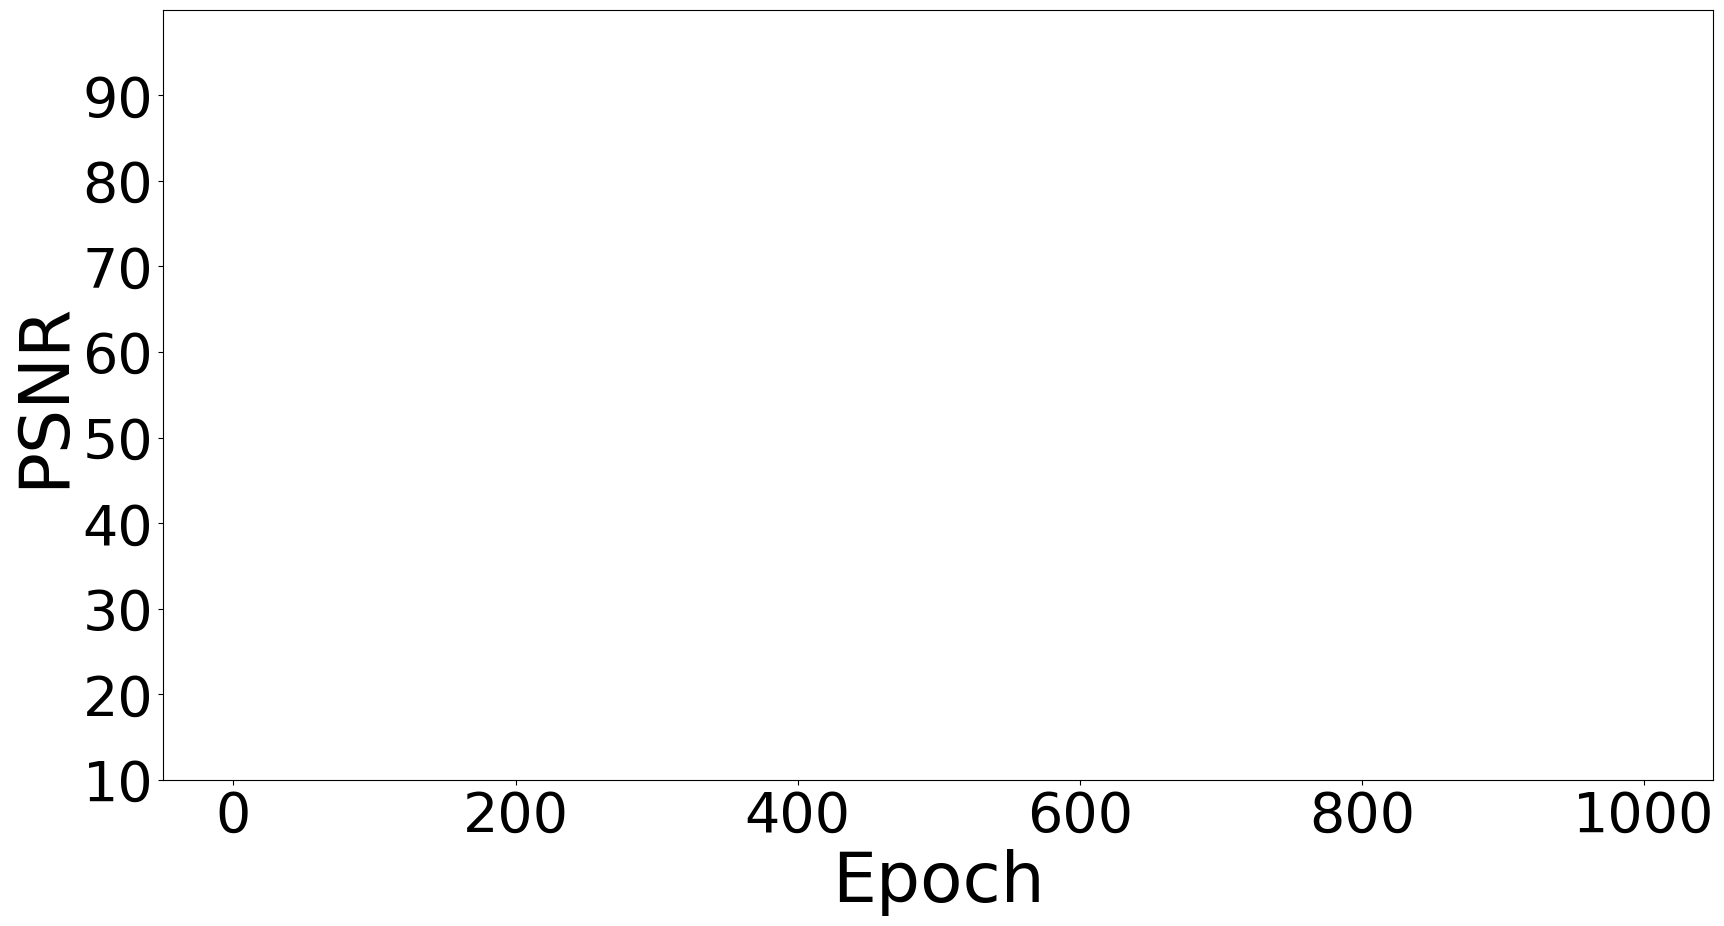

In [87]:
plt.figure(figsize=(20,10))
plt.xlabel('Epoch',fontsize=50)
plt.ylabel('PSNR',fontsize=50)
plt.xticks(fontsize=40)
plt.yticks(np.arange(0,100 , 10.0),fontsize=40)
plt.ylim(10,100)
plt.plot(x,linewidth=5.0)
plt.savefig('PSNR-IN.pdf')
plt.show()



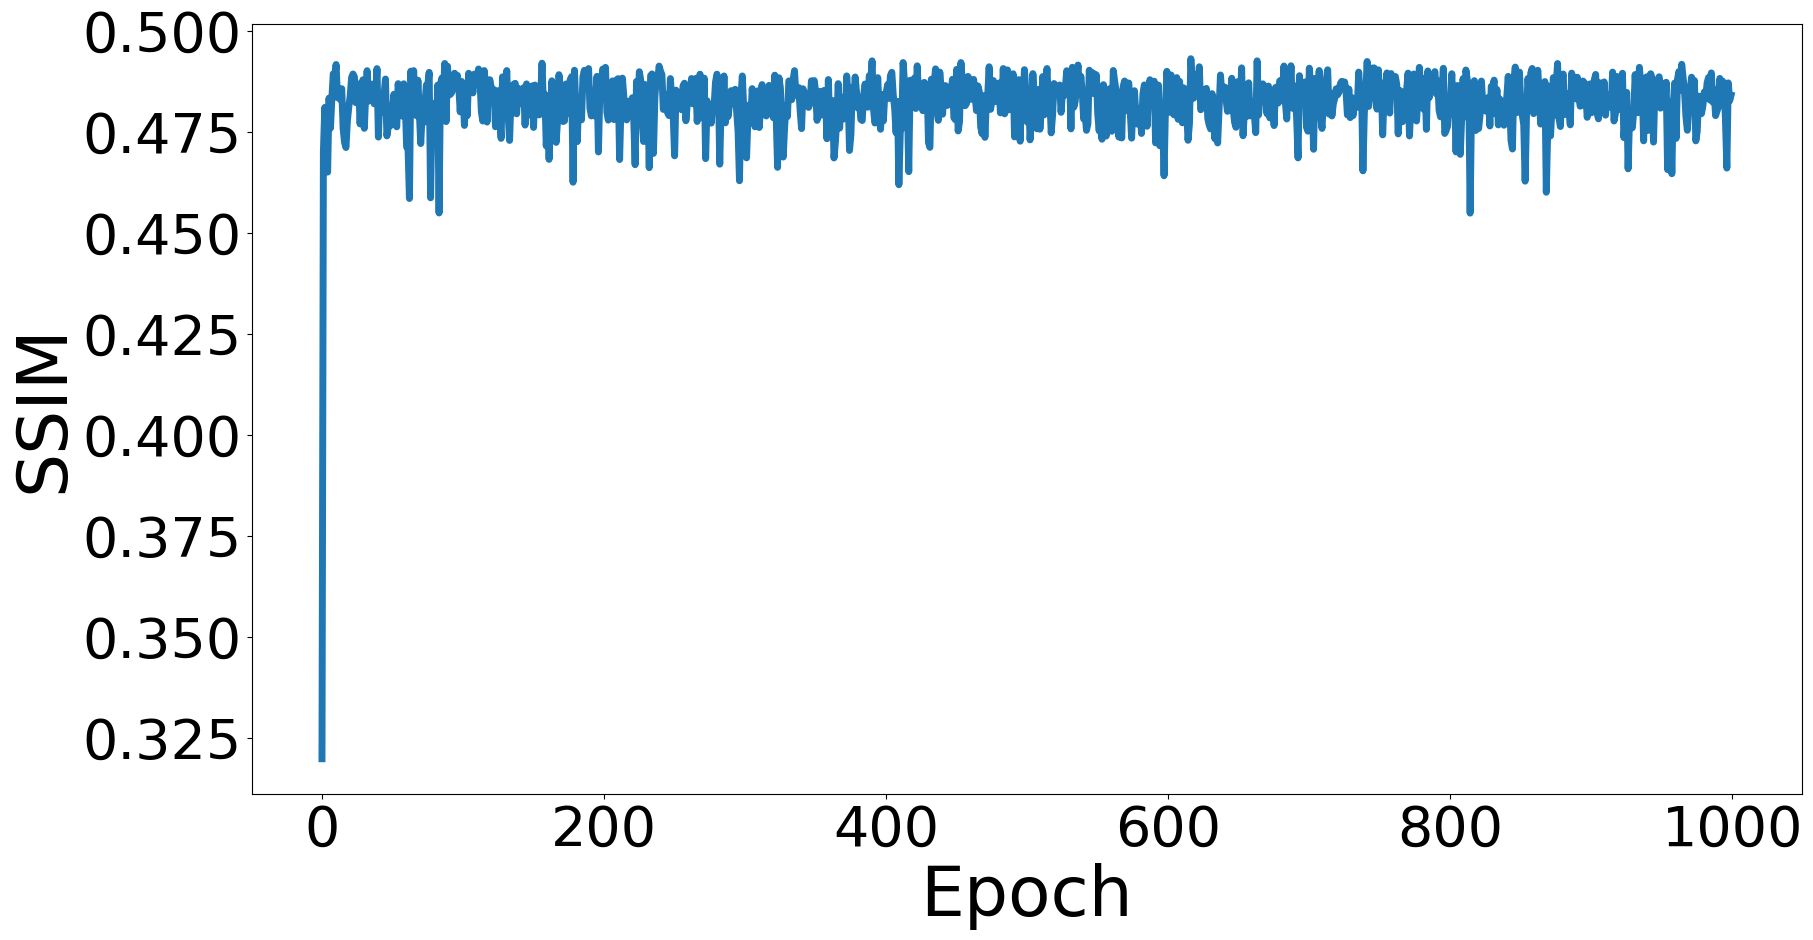

In [88]:
plt.figure(figsize=(20,10))
plt.xlabel('Epoch',fontsize=50)
plt.ylabel('SSIM',fontsize=50)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.plot(xx,linewidth=5.0)
plt.savefig('SSIM-IN.pdf')

plt.show()


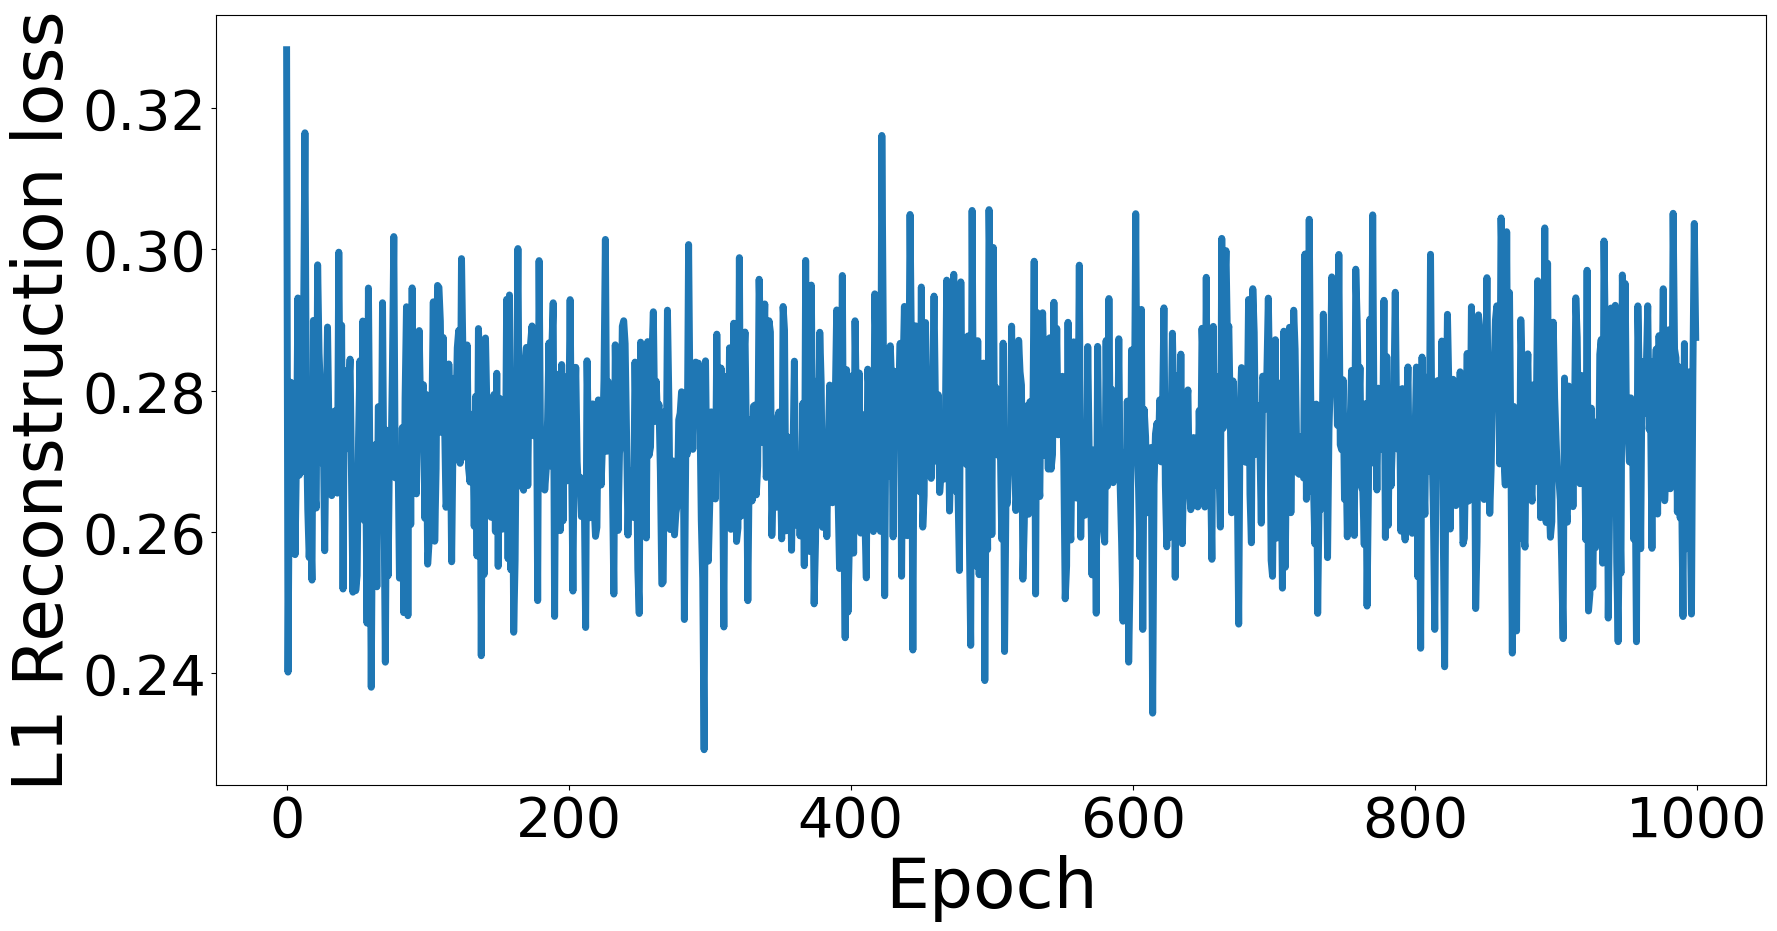

In [89]:
plt.figure(figsize=(20,10))
plt.xlabel('Epoch',fontsize=50)
plt.ylabel('L1 Reconstruction loss',fontsize=50)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.plot(xxx,linewidth=5.0)
plt.savefig('L1-IN.pdf')
plt.show()



In [67]:
from scipy.stats import entropy

In [68]:
def MeanSpectralDivergence(band_subset):

  n_row, n_column, n_band = band_subset.shape
  N = n_row * n_column
  hist = []
  for i in range(n_band):
    hist_, _ = np.histogram(band_subset[:, :, i], 256)
    hist.append(hist_ / N)
  hist = np.asarray(hist)
  hist[np.nonzero(hist <= 0)] = 1e-20  
  info_div = 0  
  for b_i in range(n_band):
    for b_j in range(n_band):
      band_i = hist[b_i].reshape(-1)/np.sum(hist[b_i])
      band_j = hist[b_j].reshape(-1)/np.sum(hist[b_j])
      entr_ij = entropy(band_i, band_j)
      entr_ji = entropy(band_j, band_i)
      entr_sum = entr_ij + entr_ji
      info_div += entr_sum
  msd = info_div * 2 / (n_band * (n_band - 1))
  return msd


In [69]:
def MeanSpectralAngle(band_subset):
    """
    Spectral Angle (SA) is defined as the angle between two bands.
    We use Mean SA (MSA) to quantify the redundancy among a band set.
    i-th band B_i, and j-th band B_j,
    SA = arccos [B_i^T * B_j / ||B_i|| * ||B_j||]
    MSA = 2/n*(n-1) * sum(SA_ij)
    Ref:
    [1]	GONG MAOGUO, ZHANG MINGYANG, YUAN YUAN. Unsupervised Band Selection Based on Evolutionary Multiobjective
    Optimization for Hyperspectral Images [J]. IEEE Transactions on Geoscience and Remote Sensing, 2016, 54(1): 544-57.
    :param band_subset: with shape (n_row, n_clm, n_band)
    :return:
    """
    n_row, n_column, n_band = band_subset.shape
    spectral_angle = 0
    for i in range(n_band):
        for j in range(n_band):
            band_i = band_subset[i].reshape(-1)
            band_j = band_subset[j].reshape(-1)
            lower = np.sum(band_i ** 2) ** 0.5 * np.sum(band_j ** 2) ** 0.5
            higher = np.dot(band_i, band_j)
            if higher / lower > 1.:
                angle_ij = np.arccos(1. - 1e-16)
                # print('1-higher-lower', higher - lower)
            # elif higher / lower < -1.:
            #     angle_ij = np.arccos(1e-8 - 1.)
                # print('2-higher-lower', higher - lower)
            else:
                angle_ij = np.arccos(higher / lower)
            spectral_angle += angle_ij
    msa = spectral_angle * 2 / (n_band * (n_band - 1))
    return msa

In [70]:
import skimage
from skimage import measure
def sumentr(band_subset,X):
  nbands = len(band_subset)
  ENTROPY=np.ones(nbands)
  for i in range(0,len(band_subset)):
    ENTROPY[i]+=skimage.measure.shannon_entropy(X[:,:,band_subset[i]])
  return np.sum(ENTROPY)

 

In [71]:
def MSA(bsnlist):
  X, _ = loadData()
  print('[',end=" ")
  for a in range(2,len(bsnlist)):
    band_subset_list = []
    for i in bsnlist[:a]:
      band_subset_list.append(X[:,:,i])     
    band_subset = np.array(band_subset_list)
    band_subset = np.stack(band_subset,axis =2)
    print(MeanSpectralAngle(band_subset),end=" ")
    if a!= len(bsnlist)-1:
      print(",",end=" ")
  print(']')
    





In [72]:
def MSD(bsnlist):
  X, _ = loadData()
  print('[',end=" ")
  for a in range(2,len(bsnlist)):
    band_subset_list = []
    for i in bsnlist[:a]:
      band_subset_list.append(X[:,:,i])     
    band_subset = np.array(band_subset_list)
    band_subset = np.stack(band_subset,axis =2)
    print(MeanSpectralDivergence(band_subset),end=" ")
    if a!= len(bsnlist)-1:
      print(",",end=" ")
  print(']')
    



In [73]:
def EntropySum(bsnlist):
  X, _ = loadData()
  print('[',end=" ")
  for a in range(2,len(bsnlist)):
    band_subset_list = []
    for i in bsnlist[:a]:
      band_subset_list.append(X[:,:,i])     
    band_subset = np.array(band_subset_list)
    band_subset = np.stack(band_subset,axis =2)
    print(sumentr(bsnlist[:a],X),end=" ")
    if a!= len(bsnlist)-1:
      print(",",end=" ")
  print(']')
    


In [74]:
MSA(bsnlist)
MSD(bsnlist)
EntropySum(bsnlist)

NameError: name 'loadData' is not defined

In [ ]:
dabs = [ 33.12881252113703 , 27.699269748852547 , 31.189050523240567 , 25.407158521806743 , 21.23842365661258 , 21.4600299169822 , 20.86248085946583 , 20.17228040657472 , 20.53299041484558 , 21.1335634998955 , 19.59117061832842 , 20.946230004039375 , 22.843494279707382 , 21.596483466175062 , 21.633130554147392 , 22.832050045391185 , 23.112561570936894 , 23.938250673675114 , 24.27697303727743 , 24.67049003424132 , 24.818116958133697 , 24.450204537801287 , 25.019421764795172 ]
bsnetconv = [ 24.926582298710684 , 21.330938461786815 , 23.04076040826106 , 21.645181998356264 , 18.691557180047244 , 20.7226257192415 , 20.180950404677475 , 18.92119239091796 , 18.14126793229048 , 18.054941145300337 , 19.2913419518319 , 21.458442690479096 , 22.376986846120094 , 26.539316782854403 , 26.364677531292276 , 26.004356791026886 , 26.06563007931373 , 27.562615680165703 , 26.816233958923476 , 26.75423730463073 , 26.76546728344344 , 26.651876628889074 , 26.170407693767313 ]
pca = [ 64.6659495569616 , 44.206964175291155 , 56.974405048963185 , 47.303760042785385 , 39.8940534876976 , 34.768743086455515 , 30.563590015282664 , 27.347606401064958 , 25.73579551531729 , 23.562059922897653 , 24.332531206971105 , 22.65318676880641 , 21.20680313199034 , 19.950365482269632 , 18.7957381872366 , 17.785780071254095 , 16.84197341100759 , 16.71704973304585 , 15.959359012341034 , 16.69296720295007 , 16.303398054778945 , 15.775575036839665 , 15.247189808858215 ]
spabs = [ 51.546751478947485 , 41.56190968855882 , 34.1507585379382 , 32.18755647433454 , 31.393008047463585 , 31.02527459658134 , 30.212480943960397 , 33.42180148091237 , 32.627589457381625 , 30.811290451152864 , 31.07497311582388 , 29.193101794721112 , 28.174085856682574 , 27.110556610241026 , 26.16396012024104 , 27.642474793195948 , 26.97927639524588 , 26.802185442574 , 26.733570979934218 , 25.614498829087168 , 24.57496106936372 , 24.260774948635653 , 24.535411090068447 ]
snmf = [ 42.687271482734026 , 69.98650272134581 , 65.56190884814379 , 64.78830503377719 , 60.283392581094056 , 57.29725635316855 , 61.48424023193987 , 65.9111624844873 , 69.81263992889625 , 66.0216268025207 , 63.44659867282022 , 59.12927876180595 , 55.89468878602123 , 54.131703617998376 , 56.680276749080825 , 59.53217131059314 , 57.16351130033321 , 54.9461367723193 , 55.23628180002861 , 54.62510055278423 , 53.74485500301176 , 52.97448803455957 , 51.9084356071723 ]
issc = [ 18.282704191681795 , 35.29174781838125 , 33.52621667208111 , 34.7570094214297 , 34.693446545983406 , 33.8470987598166 , 42.36183874938314 , 38.34479910743488 , 38.34974051412382 , 35.28287700260462 , 32.65494379097696 , 32.312139823186655 , 30.307662525527835 , 29.98966839606608 , 29.269512799967384 , 29.912423244699333 , 29.038917745855983 , 28.929037072912795 , 28.672306590798843 , 28.505889476998565 , 28.182865736586837 , 28.759689061354372 , 28.95934175252772 ]
new = [ 0.3815454878000646 , 6.781090755133797 , 9.950440828878444 , 11.237053937027174 , 27.088203156192495 , 28.32426713263673 , 31.61098768365176 , 29.18215151414016 , 30.623415605281778 , 28.31521833089382 , 27.449306705475106 , 26.808790797203535 , 26.64422017203365 , 26.15949242450031 , 24.537110949551423 , 26.60549266437586 , 25.726471570464867 , 25.336850074623072 , 24.637817130631845 , 23.95399234128613 , 23.29746143739684 , 22.647506727415077 , 22.878749722275444 ]
NSBands = list((i for i in range(2,25)))
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
methods = [dabs,bsnetconv,pca,spabs,snmf,new]
for i in methods:  print(len(i))
markerstylelist = ["8","1","2","4","*","3","5"]
scatar = []
f = plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
for method in methods:
  PLOT = plt.plot(NSBands,method,markersize=30)
  SCATTER = plt.scatter(NSBands,method,s=100)
  scatar.append(SCATTER)
plt.xlabel('Number of Selected Bands',fontsize=40)
plt.ylabel('MSD',fontsize=40)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylim(1,80)
plt.xlim(1,25)
plt.legend(scatar,['DARecNet-BS','BSNet-Conv','PCA','SpaBS','SNMF','New'],loc='best',fontsize='xx-large',shadow=True,prop={'size': 26},bbox_to_anchor=(0.5, 0.5, 0.5, 0.5))
plt.show()
f.savefig("MSD-IN.pdf", bbox_inches='tight')